# Titanic Survival

Predict survival on the Titanic

https://www.kaggle.com/competitions/titanic/overview



In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import model_selection, ensemble
import tensorflow as tf

In [2]:
# Read training data into pandas dataset
dataset = pd.read_csv("data/train.csv")

# Inspect the training data
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
# The [Cabin, Sex, Embarked] columns contain categorical data, so let's factorize these
cabin_codes, cabin_uniques = pd.factorize(dataset["Cabin"])
dataset["Cabin_Factorized"] = cabin_codes
sex_codes, sex_uniques = pd.factorize(dataset["Sex"])
dataset["Sex_Factorized"] = sex_codes
embarked_codes, embarked_uniques = pd.factorize(dataset["Embarked"])
dataset["Embarked_Factorized"] = embarked_codes

In [4]:
# the 'Name' column contains an individuals title, which could be correlated with expected survival
# lets explore that theory by creating a new 'Title' column
def createTitleColumn(dataset: pd.DataFrame) -> pd.DataFrame:
    titles = dataset["Name"].apply(lambda x: x.split(",")[1].split(" ")[1].strip())
    titles.value_counts()
    title_codes, title_uniques = pd.factorize(titles)
    dataset["Title"] = title_codes
    return dataset

dataset = createTitleColumn(dataset)

array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>,
        <Axes: title={'center': 'Cabin_Factorized'}>,
        <Axes: title={'center': 'Sex_Factorized'}>],
       [<Axes: title={'center': 'Embarked_Factorized'}>,
        <Axes: title={'center': 'Title'}>, <Axes: >]], dtype=object)

Survived               1.000000
Sex_Factorized         0.543351
Title                  0.290260
Cabin_Factorized       0.270495
Fare                   0.257307
Embarked_Factorized    0.101849
Parch                  0.081629
PassengerId           -0.005007
SibSp                 -0.035322
Age                   -0.077221
Pclass                -0.338481
Name: Survived, dtype: float64

array([[<Axes: xlabel='PassengerId', ylabel='PassengerId'>,
        <Axes: xlabel='Survived', ylabel='PassengerId'>,
        <Axes: xlabel='Pclass', ylabel='PassengerId'>,
        <Axes: xlabel='Age', ylabel='PassengerId'>,
        <Axes: xlabel='SibSp', ylabel='PassengerId'>,
        <Axes: xlabel='Parch', ylabel='PassengerId'>,
        <Axes: xlabel='Fare', ylabel='PassengerId'>,
        <Axes: xlabel='Cabin_Factorized', ylabel='PassengerId'>,
        <Axes: xlabel='Sex_Factorized', ylabel='PassengerId'>,
        <Axes: xlabel='Embarked_Factorized', ylabel='PassengerId'>,
        <Axes: xlabel='Title', ylabel='PassengerId'>],
       [<Axes: xlabel='PassengerId', ylabel='Survived'>,
        <Axes: xlabel='Survived', ylabel='Survived'>,
        <Axes: xlabel='Pclass', ylabel='Survived'>,
        <Axes: xlabel='Age', ylabel='Survived'>,
        <Axes: xlabel='SibSp', ylabel='Survived'>,
        <Axes: xlabel='Parch', ylabel='Survived'>,
        <Axes: xlabel='Fare', ylabel='Survived'>,


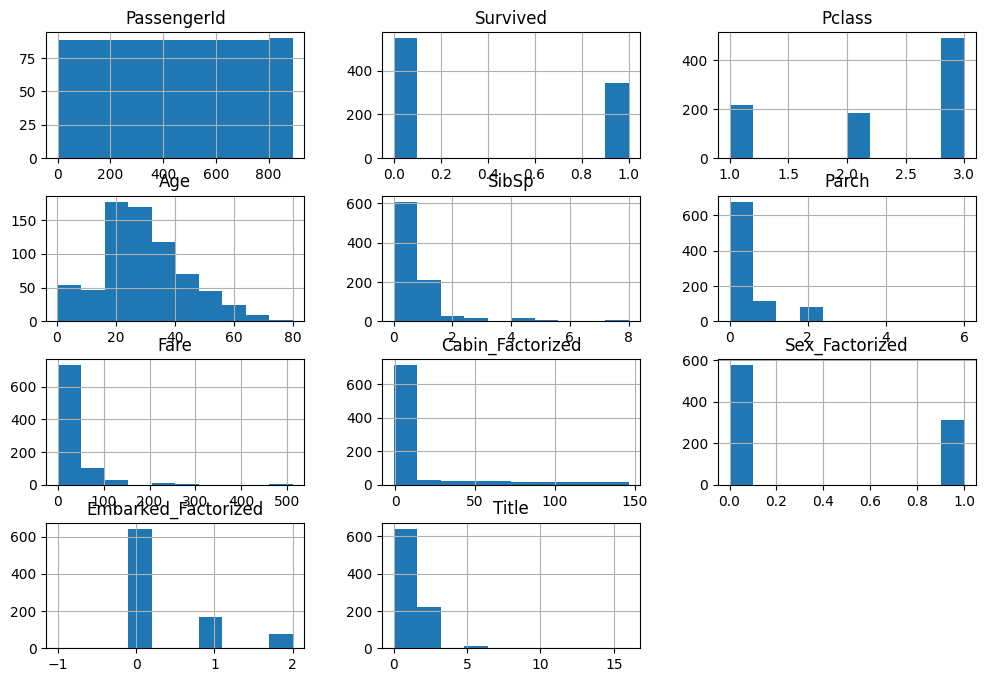

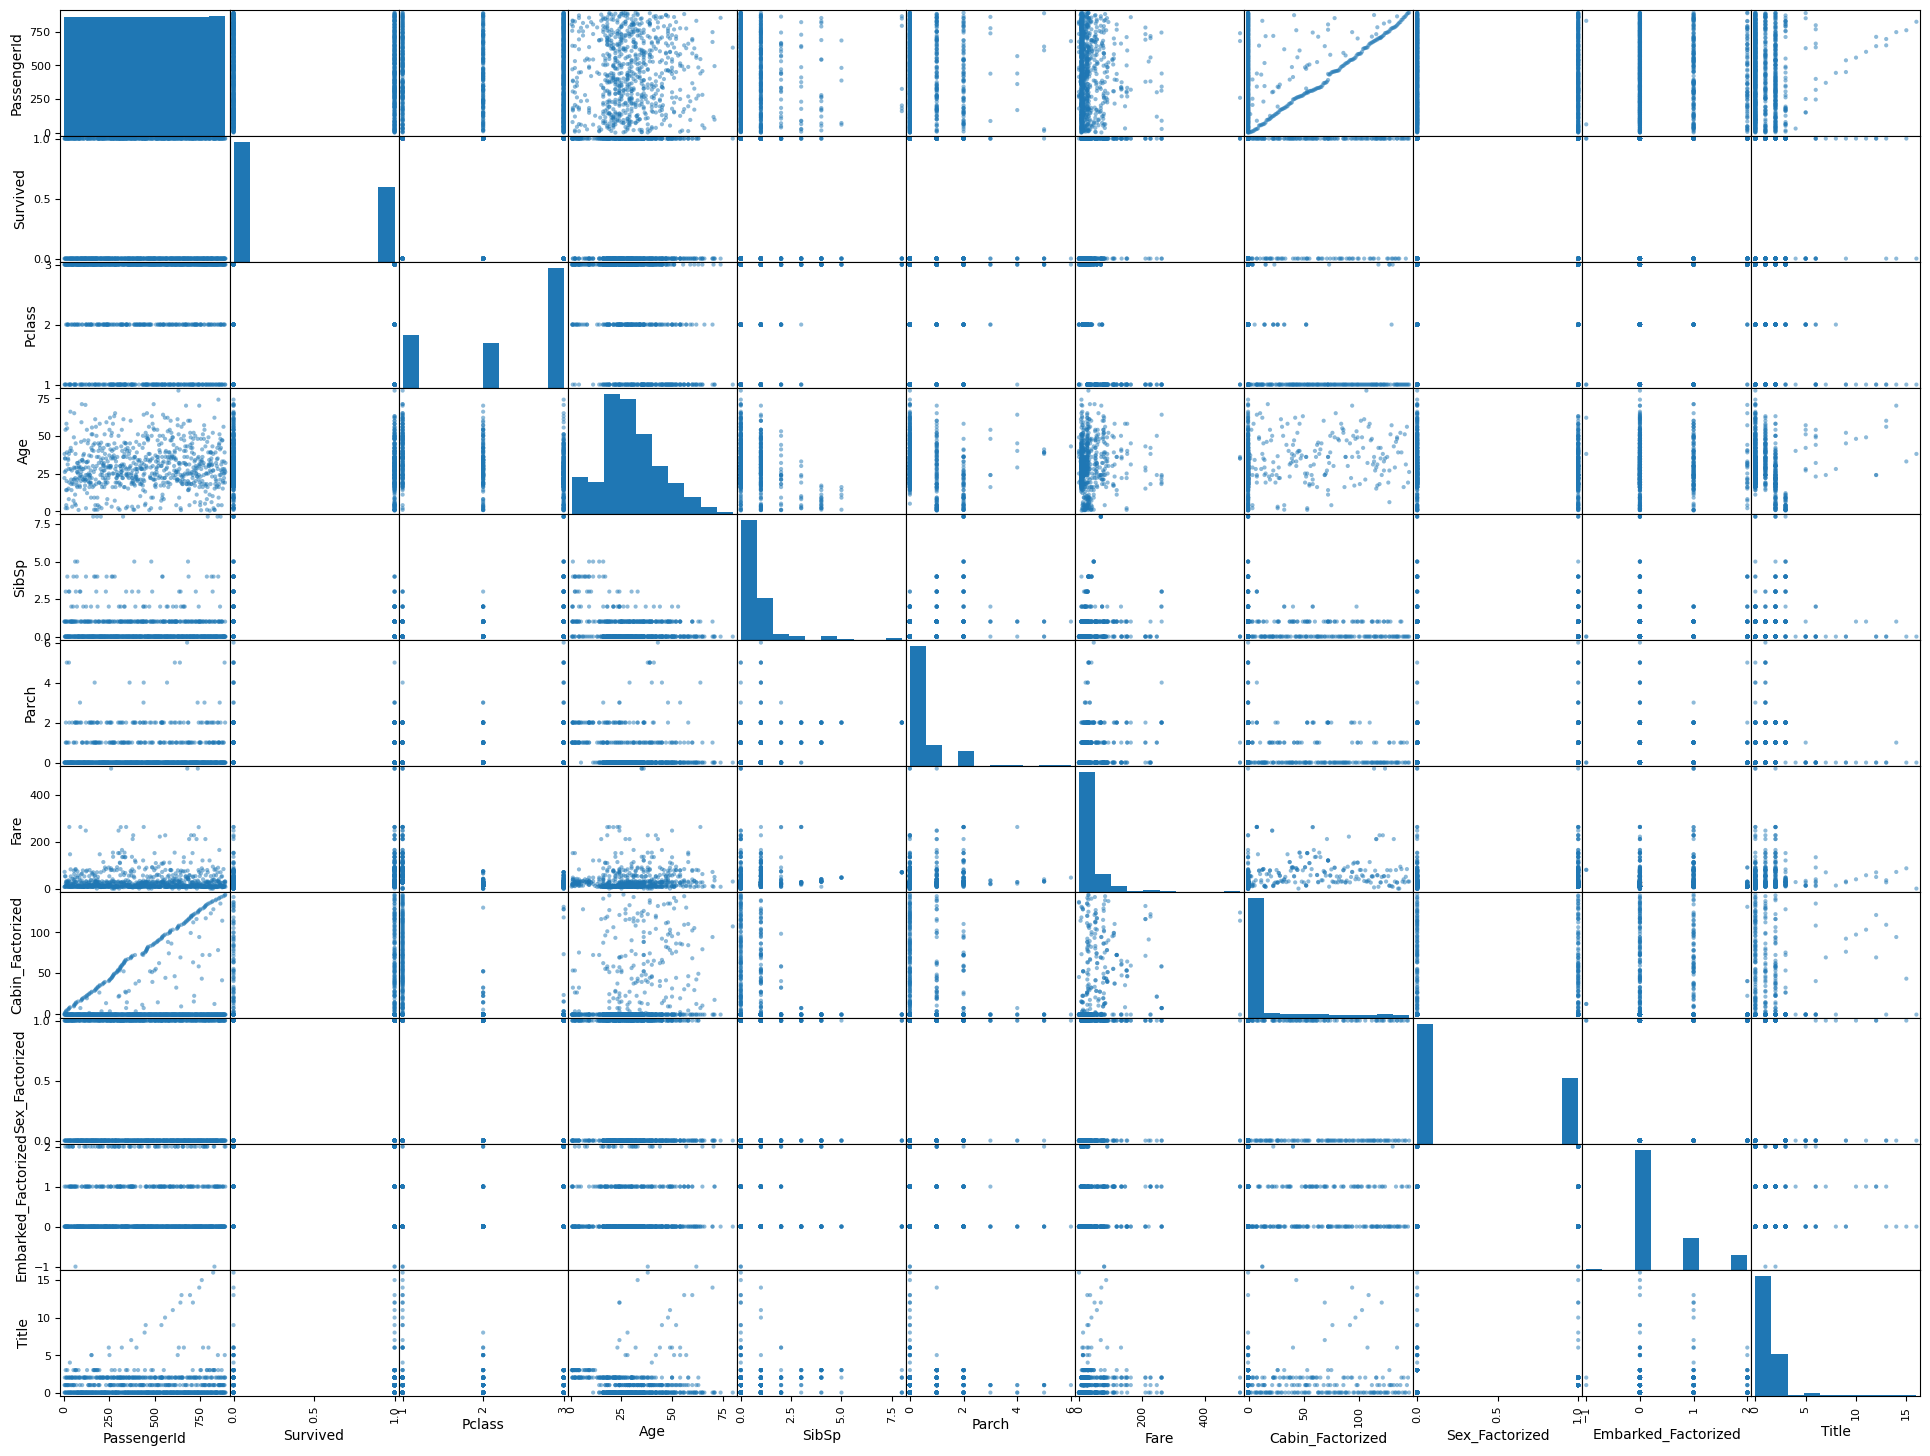

In [5]:
# inspect hist, correlation, and scatter matrix
dataset.hist(figsize=(12,8))
corr_matrix = dataset.select_dtypes(exclude=object).corr()
corr_matrix["Survived"].sort_values(ascending=False)
pd.plotting.scatter_matrix(dataset, figsize=(24,18))

It turns out our extracted 'Title' column has a non-trivial p-score!

In [6]:
# Drop unused dataset columns
def dropUnusedColumns(dataset: pd.DataFrame) -> pd.DataFrame:
    # we're ignoring the "Ticket" category because its 560 categories are larger than the 250 histGradTree bin max limit
    dataset = dataset.select_dtypes(exclude=object)
    try:
        dataset = dataset.drop("PassengerId", axis=1)
    except:
        pass
    return dataset

dataset = dropUnusedColumns(dataset)

In [7]:
# split dataset into train, test
train_x, test_x = sk.model_selection.train_test_split(dataset, train_size=0.8, random_state=10)
train_y = train_x.pop("Survived")
test_y = test_x.pop("Survived")
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 57 to 265
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Pclass               712 non-null    int64  
 1   Age                  577 non-null    float64
 2   SibSp                712 non-null    int64  
 3   Parch                712 non-null    int64  
 4   Fare                 712 non-null    float64
 5   Cabin_Factorized     712 non-null    int64  
 6   Sex_Factorized       712 non-null    int64  
 7   Embarked_Factorized  712 non-null    int64  
 8   Title                712 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 55.6 KB


In [8]:
# gradient boosted tree
clf_gbt = sk.ensemble.HistGradientBoostingClassifier(max_iter=100, categorical_features=["Pclass", "Cabin_Factorized", "Sex_Factorized", "Embarked_Factorized", "Title"]).fit(train_x, train_y)
clf_gbt.score(test_x, test_y)

0.8435754189944135

In [9]:
# Now let's train our tree on the full training suite
try:
    dataset_y = dataset.pop("Survived")
except:
    pass
dataset_x = dataset
clf_gbt = sk.ensemble.HistGradientBoostingClassifier(max_iter=100, categorical_features=["Pclass", "Cabin_Factorized", "Sex_Factorized", "Embarked_Factorized", "Title"]).fit(dataset_x, dataset_y)

# helper function to encode item as factorized representation given 'uniques' array
def f(x, uniques_arr):
    if x in uniques_arr:
        return np.where(uniques_arr==x)[0][0]
    else:
        return -1

# Preprocess our test data
test = pd.read_csv("data/test.csv")
test["Cabin_Factorized"] = test["Cabin"].apply(lambda x: f(x, cabin_uniques))
test["Sex_Factorized"] = test["Sex"].apply(lambda x: f(x, sex_uniques))
test["Embarked_Factorized"] = test["Embarked"].apply(lambda x: f(x, embarked_uniques))
test = createTitleColumn(test)
test_results = test.pop("PassengerId")
test = dropUnusedColumns(test)
test.info()
# Generate predictions using our tree trained on the full training suite
test_preds = clf_gbt.predict(test)
test_results = pd.DataFrame(test_results)
test_results.insert(1, "Survived", test_preds)
test_results.to_csv("predictions.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Pclass               418 non-null    int64  
 1   Age                  332 non-null    float64
 2   SibSp                418 non-null    int64  
 3   Parch                418 non-null    int64  
 4   Fare                 417 non-null    float64
 5   Cabin_Factorized     418 non-null    int64  
 6   Sex_Factorized       418 non-null    int64  
 7   Embarked_Factorized  418 non-null    int64  
 8   Title                418 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 29.5 KB


Our gradient boosted tree approach scores 0.73684 on kaggle
Let's see if we can do better with a deep learning model

In [10]:
# First we need to review our train and test data for missing values
dataset_train = pd.read_csv("data/train.csv")
dataset_test = pd.read_csv("data/test.csv")
dataset_train.info()
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

Looks like we'll need to discard the [Age, Cabin] columns from our model, due to the number of missing values
There are two missing 'Embarked' items, we can populate these with the most frequent value
There's also one missing Fare in the test dataset that will need to populate with a reasonable value (mean)

In [11]:
# Exract our 'Title' column
titles = dataset_train["Name"].apply(lambda x: x.split(",")[1].split(" ")[1].strip())
dataset_train["Title"] = titles
titles = dataset_test["Name"].apply(lambda x: x.split(",")[1].split(" ")[1].strip())
dataset_test["Title"] = titles

# Populate missing Embarked fields
most_common_port = dataset_train["Embarked"].mode()[0]
dataset_train["Embarked"] = dataset_train["Embarked"].fillna(most_common_port)

# Populate missing Fare field
average_fare = dataset_test["Fare"].mean()
dataset_test["Fare"] = dataset_test["Fare"].fillna(average_fare)

# Discard unused columns
try:
    dataset_train = dataset_train.drop(["Age"], axis=1)
    dataset_train = dataset_train.drop(["PassengerId"], axis=1)
    dataset_train = dataset_train.drop(["Name"], axis=1)
    dataset_train = dataset_train.drop(["Cabin"], axis=1)
    dataset_test = dataset_test.drop(["Age"], axis=1)
    dataset_test = dataset_test.drop(["PassengerId"], axis=1)
    dataset_test = dataset_test.drop(["Name"], axis=1)
    dataset_test = dataset_test.drop(["Cabin"], axis=1)
except:
    pass

# Split dataset into train, val
train_x, val_x = sk.model_selection.train_test_split(dataset_train, train_size=0.8, random_state=10)
train_y = train_x.pop("Survived")
val_y = val_x.pop("Survived")

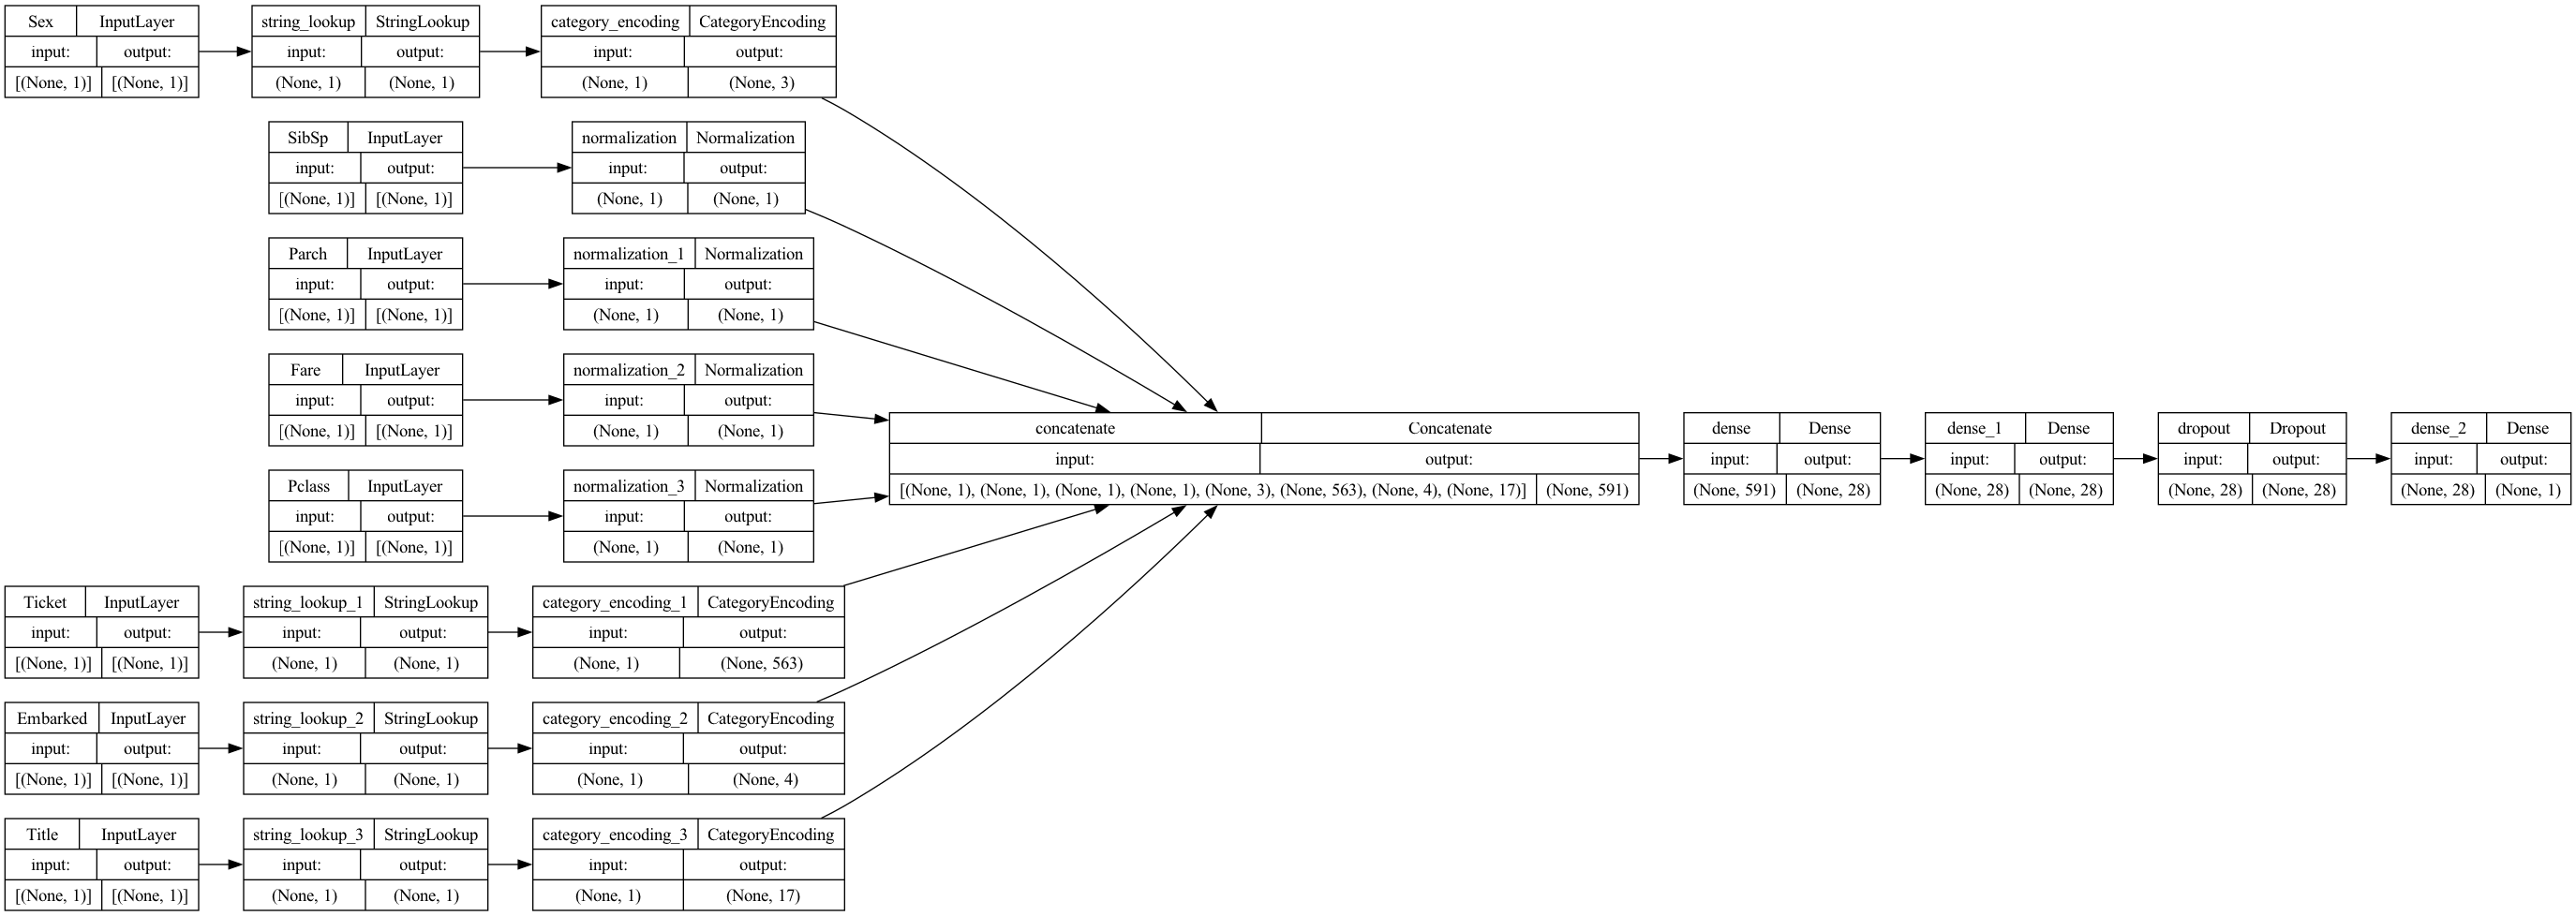

In [12]:
# Normalization approach cribbed from https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
# Preprocess numerical features
def get_normalization_layer(feature_ds):
  # Create a Normalization layer for the feature.
  normalizer = tf.keras.layers.Normalization(axis=None)
  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)
  return normalizer

# Preprocess categorical features
def get_category_encoding_layer(feature_ds, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = tf.keras.layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = tf.keras.layers.IntegerLookup(max_tokens=max_tokens)
  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)
  # Encode the integer indices.
  encoder = tf.keras.layers.CategoryEncoding(num_tokens=index.vocabulary_size())
  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))


all_inputs = []
encoded_features = []

# Create input, normalization layers for numerical features
for header in ['SibSp', 'Parch', 'Fare', 'Pclass']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(train_x[header])
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

# Create input, normalization layers for categorical features
for header in ['Sex', 'Ticket', 'Embarked', 'Title']:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(train_x[header], dtype='string')
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

# Define core model layers
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(28, activation="relu")(all_features)
x = tf.keras.layers.Dense(28)(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)

# Compile model
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])

# Plot model for visual inspection
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [13]:
# Convert dataframes to tf datasets
def df_to_dataset(x: pd.DataFrame, y=None, batch_size=50):
    df = x.copy()
    df = {key: value.values[:,tf.newaxis] for key, value in x.items()}
    if y is None:
        ds = tf.data.Dataset.from_tensor_slices((dict(df)))
    else:
        ds = tf.data.Dataset.from_tensor_slices((dict(df), y))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

train_dataset = df_to_dataset(train_x, train_y)
val_dataset = df_to_dataset(val_x, val_y)

In [14]:
# Fit model
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0005, restore_best_weights=True, patience=2)]
model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/30
15/15 [==============================] - 0s 10ms/step - loss: 0.6856 - accuracy: 0.5997 - val_loss: 0.6337 - val_accuracy: 0.6536
Epoch 2/30
15/15 [==============================] - 0s 1ms/step - loss: 0.6231 - accuracy: 0.6053 - val_loss: 0.5703 - val_accuracy: 0.6536
Epoch 3/30
15/15 [==============================] - 0s 1ms/step - loss: 0.5694 - accuracy: 0.6208 - val_loss: 0.5056 - val_accuracy: 0.7095
Epoch 4/30
15/15 [==============================] - 0s 1ms/step - loss: 0.5097 - accuracy: 0.6994 - val_loss: 0.4452 - val_accuracy: 0.8156
Epoch 5/30
15/15 [==============================] - 0s 1ms/step - loss: 0.4524 - accuracy: 0.7739 - val_loss: 0.4076 - val_accuracy: 0.8380
Epoch 6/30
15/15 [==============================] - 0s 1ms/step - loss: 0.4110 - accuracy: 0.8385 - val_loss: 0.3930 - val_accuracy: 0.8380
Epoch 7/30
15/15 [==============================] - 0s 3ms/step - loss: 0.3863 - accuracy: 0.8413 - val_loss: 0.3892 - val_accuracy: 0.8324
Epoch 8/30
15/15 [=

In [15]:
# Run inference on test data
dataset_test_ds = df_to_dataset(dataset_test)
predictions = model.predict(dataset_test_ds)
predictions = tf.cast(tf.math.round(tf.nn.sigmoid(predictions)), tf.int8)
test_results["Survived"] = predictions
test_results.to_csv("predictions_nn.csv", index=False)

9/9 [==============================] - 0s 632us/step


Our simple neural net scores 0.76794 on the kaggle submission, which is slightly better than our boosted gradient tree approach
We could optimize our model further by using k-means clustering for train/test data, and using hyperparameter tuning (KerasTuner or Vizier)